## How does joining with an L2 norm compare to joining on Haversine? 

In [105]:
#Load an L2 norm file
import pandas as pd
cols = ['latitude_ERA', 'longitude_ERA','MODIS_LST','time']

root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/'
L2 = pd.read_parquet(root+'MODIS_ERA_2016_01.parquet',columns=cols)
Haver = pd.read_parquet(root+'Haversine_MODIS_ERA_2016_01.parquet',columns=cols)

In [106]:
#Left outer join - L2 has more rows
df = pd.merge(L2,Haver,on=['latitude_ERA', 'longitude_ERA','time'], how = 'outer',suffixes=('_L2', '_haver'))

In [107]:
#Get the difference
df['delta'] = df.MODIS_LST_L2 - df.MODIS_LST_haver #difference

MAX =  19.816483
MIN =  -27.768097


,latitude_ERA,longitude_ERA,MODIS_LST_L2,time,MODIS_LST_haver,delta
2807749,-68.430869,-66.240000,250.949615,2016-01-29 18:00:00,231.133133,19.816483
506806,67.025720,-162.000000,255.652252,2016-01-06 00:00:00,238.965515,16.686737
400183,68.711899,-94.074074,249.023315,2016-01-04 20:00:00,234.076660,14.946655
2524772,-69.273959,-66.750000,251.383881,2016-01-26 18:00:00,237.197784,14.186096
2834223,-68.992929,143.250000,256.857391,2016-01-30 04:00:00,242.807343,14.050049
2780078,61.124090,32.625000,260.588501,2016-01-29 11:00:00,247.300003,13.288498
506896,68.711899,-155.555556,252.067825,2016-01-06 00:00:00,239.866669,12.201157
2830330,68.711899,-136.296296,259.010681,2016-01-29 23:00:00,247.009628,12.001053
2524787,-68.711899,-64.444444,264.378693,2016-01-26 18:00:00,252.496002,11.882690
2004844,67.025720,57.333333,249.202728,2016-01-21 10:00:00,237.619995,11.582733


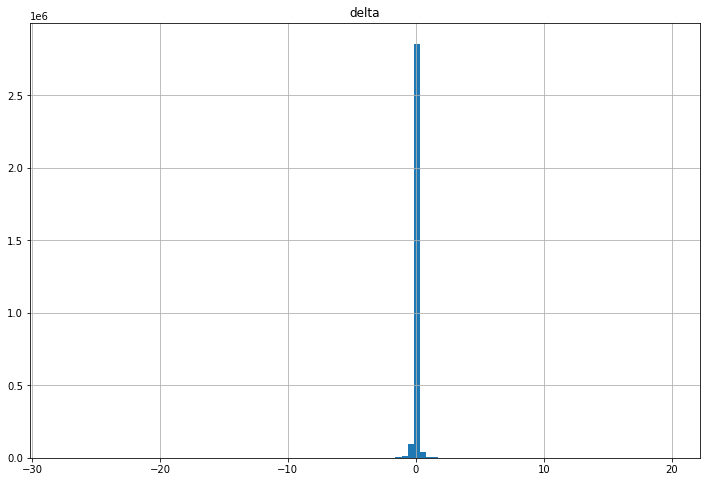

In [109]:
#Histogram of the differences
df.hist(column=['delta'],figsize=(12,8),bins=100)
print ('MAX = ', df.delta.max())
print ('MIN = ', df.delta.min())
display(df.sort_values(by='delta',ascending=False).head(20))

In [112]:
#Plot a map

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    

In [117]:
dfNZ = df[df.delta != 0.0]

In [120]:
dfNZ=dfNZ.dropna()

In [122]:
dfNZ_grouped = dfNZ.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year


In [123]:
dfNZ_grouped

,latitude_ERA,longitude_ERA,MODIS_LST_L2,MODIS_LST_haver,delta
0,-69.554988,-72.75,271.181580,271.250244,-0.068658
1,-69.554988,-72.00,271.471344,271.449615,0.021741
2,-69.554988,-71.25,265.713684,265.922668,-0.208979
3,-69.554988,-70.50,264.184753,264.428986,-0.244245
4,-69.554988,-69.75,265.030792,265.378448,-0.347645
...,...,...,...,...,...
52959,69.836018,171.75,245.790863,245.974228,-0.183363
52960,70.117048,168.00,239.995560,240.081802,-0.086244
52961,70.117048,168.75,241.673630,241.691437,-0.017809
52962,70.117048,171.00,245.575531,245.569229,0.006304


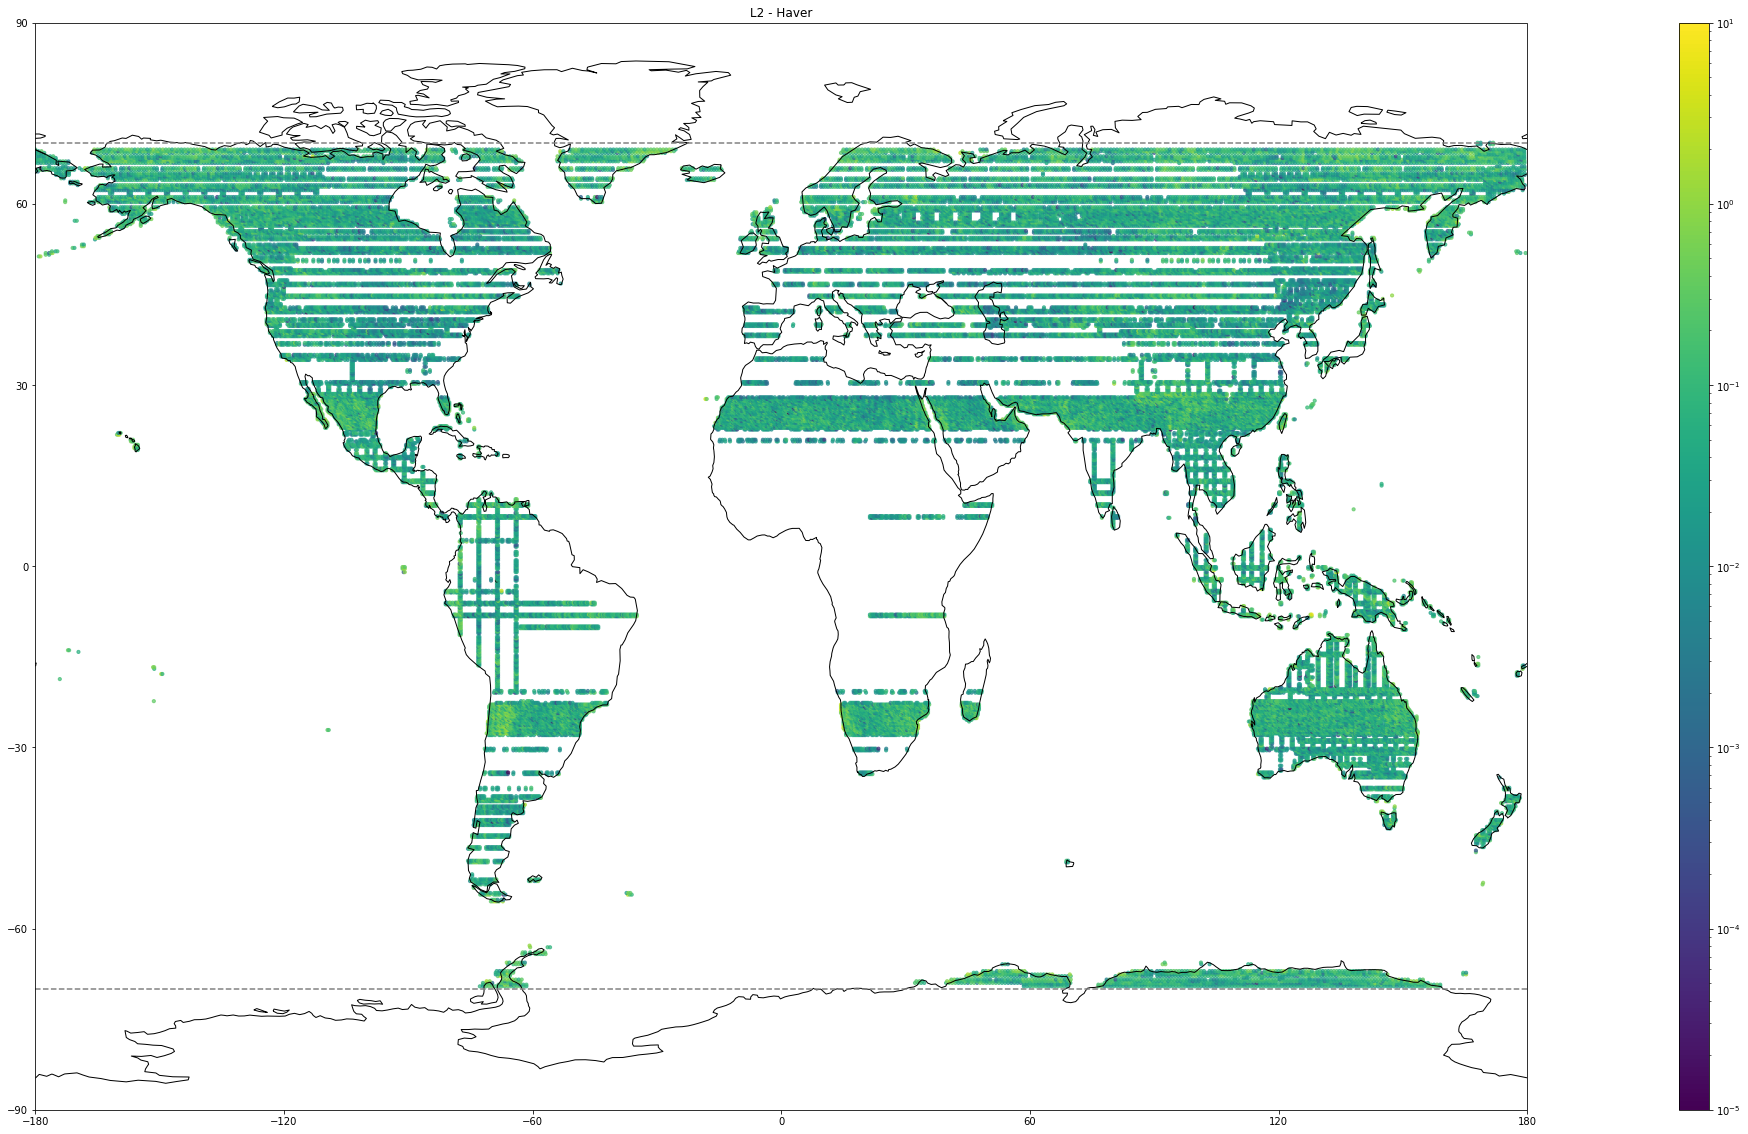

In [126]:
plot_map(dfNZ_grouped,'delta',vmin=1e-5,vmax=1e1,cmap=plt.cm.viridis,logscale=True,title='L2 - Haver',limits=None,markersize=10)